Based on this paper https://doi.org/10.1088/2634-4386/ac1b75

In [1]:
import sys
sys.path.append('/import/silo2/aloe8475/Documents/edamame')

In [2]:
from scipy.io import loadmat, savemat
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import networkx as nx
from edamame import *
from tqdm.notebook import tqdm
import os
import edamame.core.wires as wires
from random import choice
from IPython.core.debugger import set_trace
import pickle 
import _pickle as cPickle
import gzip

def compressed_pickle(obj, filename,protocol=-1):
    with gzip.open(filename, 'wb') as f:
        cPickle.dump(obj, f, protocol)
def decompress_pickle(file):
    with gzip.open(file, 'rb') as f:
        loaded_object = cPickle.load(f,encoding="bytes") #change this for python 2
        return loaded_object

In [3]:
density=0.10
densityName=str(density).replace('.','p')

dataLoc='/import/silo2/aloe8475/Documents/Data/Functional Connectivity/Hierarchical Networks/Deep NWN Hierarchy/Density '+"{:.2f}".format(density)+'/'
saveFig='/import/silo2/aloe8475/Documents/Data/Figures/Functional Connectivity/'

In [4]:
dataLoc

'/import/silo2/aloe8475/Documents/Data/Functional Connectivity/Hierarchical Networks/Deep NWN Hierarchy/Density 0.10/'

In [5]:
import glob
#Load all files in folder:
mat_files = glob.glob(dataLoc+'*.mat')
mat_files=sorted(mat_files)
# List for stroring all the data
alldata = []

# Iterate mat files
for fname in mat_files:
    # Load mat file data into data.
    data = loadmat(fname)

    # Append data to the list
    alldata.append(data)

subres=alldata[:10] #first 10 networks are 100nw 
res=alldata[-10:] #last 10 networks are 300nw


In [6]:
a=[]
b=[]
for i in range(len(subres)):
    subres[i]['G']=nx.from_numpy_array(subres[i]['adj_matrix'])
    res[i]['G']=nx.from_numpy_array(res[i]['adj_matrix'])
    a.append(subres[i]['G'])
    b.append(res[i]['G'])
    
# res=loadmat(dataLoc+'asn_nw_00302_nj_01492_seed_042_avl_10.00_disp_01.00_lx_41.00_ly_41.00.mat')#edamame.core.generate_network(300,dispersion=125,mean_length=100,this_seed=42) #300 nodes, 15000 edges
    
#edamame.core.generate_network(100,dispersion=110,mean_length=100,this_seed=42) #100 nodes, 450 edges

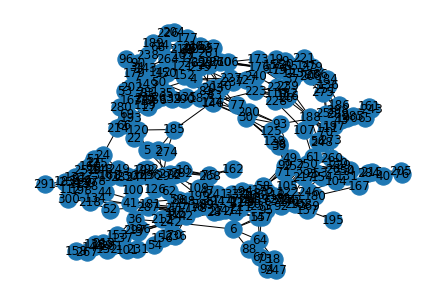

In [20]:
nx.draw(b[-3],with_labels=True)
plt.show()

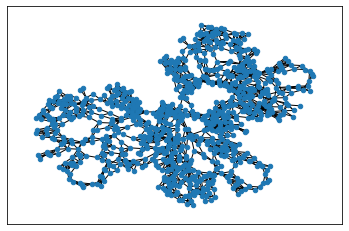

In [22]:
#COMBINE SUBRESERVOIRS PHYSICALLY
aa=b[-3]
bb = nx.union(aa,aa, rename=('a-', 'b-'))
bb.add_edge('a-63', 'b-64')
bb.add_edge('a-45', 'b-52')
bb.add_edge('a-79', 'b-35')

# plt.figure()
# nx.draw_networkx(b,with_labels=True,node_size=500)

# plt.figure()
aa=nx.relabel_nodes(aa, { n: str(n) if n==0 else 'c-'+str(n) for n in  aa.nodes })
c = nx.union(aa,bb)
c.add_edge('b-63', 'c-64')
c.add_edge('b-45', 'c-52')
c.add_edge('b-79', 'c-35')

pos=nx.kamada_kawai_layout(c)
nx.draw_networkx(c,pos=pos,with_labels=False,node_size=20)
plt.show()

#rename nodes to normal
start = 1
c = nx.convert_node_labels_to_integers(c,first_label=start)

In [41]:
elecDrain=[105,761,367]
elecSource=[23,320,26,74,145,317,129,247,141]


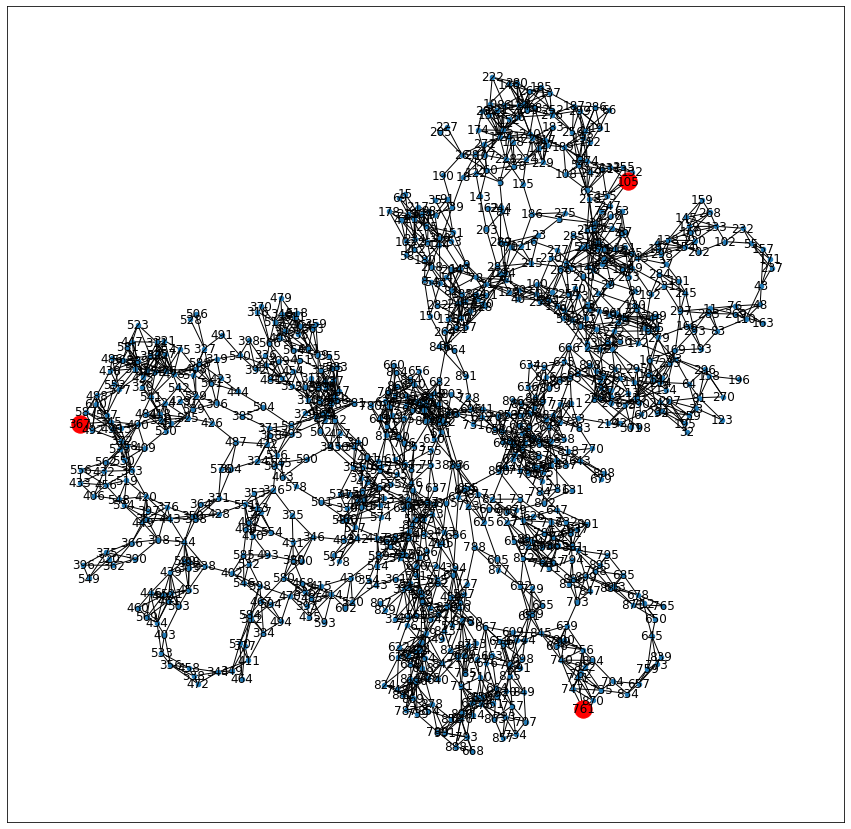

In [44]:
plt.figure(figsize=(15,15))
pos=nx.kamada_kawai_layout(c)
nx.draw_networkx(c,pos=pos,with_labels=True,node_size=20)
# nx.draw_networkx_nodes(elecSource,node_color='g',pos=pos)
nx.draw_networkx_nodes(elecDrain,node_color='r',pos=pos)
plt.show()

### MEMORY CAPACITY TASK (MC)

In [ ]:
# Global Functions:
def addSubReservoir(graph,sim,numInputs=10,signal=[],amp=2,seed=42,removeSources=False,analysisType=[]):
    
    temp=list(range(len(sim.wireVoltage.T)))
    if removeSources:
        for j in range(len(sim.sources)):
            temp.remove(sim.sources[j]) 
    if sim.drains[0] in temp:
        temp.remove(sim.drains[0])

    sampleIdx=np.random.choice(temp,numInputs,replace=False)

    wireVoltages=sim.wireVoltage[:,sampleIdx]
    drains=sim.drains[0]
    electrodes=list(np.hstack((sampleIdx,drains)))
    
    if analysisType=='MG':
        new_sim,node_list=get_MG_deep(graph,amp=amp,signal=signal,voltageInputs=wireVoltages.T,elecs=electrodes,return_sim=True,seed=seed)
    elif analysisType=='NARMA':
        new_sim,node_list=get_NARMA_deep(graph,amp=amp,signal=signal,voltageInputs=wireVoltages.T,elecs=electrodes,return_sim=True,seed=seed)
    elif analysisType=='MC':
        new_sim,node_list=get_MC_deep(graph,amp=amp,signal=signal,voltageInputs=wireVoltages.T,elecs=electrodes,return_sim=True,seed=seed)

    return new_sim,node_list

In [1112]:
# FUNCTIONS
def MC_k_new(network, k = 1, node_list=[], transient = 100):
#     node_list=n_outs#len(node_list)
    signal = network.stimulus[0].signal[transient:]
    wire_voltage = network.wireVoltage[transient:]
    T, N = wire_voltage.shape
#     node_list = np.random.choice(range(0, N), n_outs, replace = False)
    lhs = wire_voltage[k:,node_list]
    rhs = signal[:-k]
    try:
        weight = np.linalg.lstsq(lhs, rhs, rcond = None)[0]
        result = np.matmul(lhs, weight)
        mc = (np.cov(rhs, result)[0,1])**2/(np.var(signal[k:])*np.var(result))
        return mc
    except:
        return 0

def get_MC_deep(Graph,amp = 2,signal=[],voltageInputs=[],elecs=[], dt = 0.01, dur = 1, n_outs = 100, init_state = None, return_sim = False,seed=42):
    ampName=str(amp).replace('.','p')
    np.random.seed(seed)
    stimulus=[]
    if elecs:
        electrodes=elecs
        contactMode='preSet'
        for volt in voltageInputs:
            stimulus.append(stimulus__(biasType='Custom',T=10,dt=dt,customSignal=volt))#signal_expand(np.random.random(1000)*2*volt-volt, dur)))
        stimulus.append(stimulus__(biasType='Drain',T=10,dt=dt)) #we don't want this drain to be active during training
    else:
        electrodes=None
        contactMode='farthest'
        stimulus.append(stimulus__(biasType='Custom',T=10,dt=dt,customSignal=signal_expand((np.random.random(1000)*2*amp-amp), dur)))
        stimulus.append(stimulus__(biasType='Drain',T=10,dt=dt)) #we don't want this drain to be active during training
    
    simRAND = runSim(connectivity__(graph=Graph), T = 10, dt = dt,
                stimulus=stimulus,
#                 biasType = 'Custom', customSignal = signal_expand(np.random.random(1000)*2*amp-amp, dur), 
                junctionMode = 'tunneling', 
                electrodes=electrodes,
                contactMode = contactMode,
                findFirst=False, disable_tqdm=True)
    
    nodesList=[]
    for i in range(len(Graph.nodes)):
        nodesList.append(i)

    mcRAND = [MC_k_new(simRAND, m, node_list=nodesList) for m in range(dur, len(nodesList)*dur, dur)]
    
    if return_sim:
        return np.sum(mcRAND),simRAND, nodesList#simRAND, nodesList #
    else:
        return nodesList

In [1113]:
numRep=10#number of repeats
seeds=np.random.randint(1000,size=numRep) #random seeds

In [1126]:
#SINGLE NETWORK:
def runSingleMC(nw,numRep,amp=2):
    MC_single=np.zeros((len(nw),numRep))
    for i in tqdm(range(len(nw))):
        for j in tqdm(range(numRep)):
            MC_single[i][j],sim_single,node_list=get_MC_deep(nw[i],amp=amp,return_sim=True,seed=seeds[j])
            
    return MC_single

In [1057]:
MC_single=runSingleMC(b,numRep)

In [1059]:
print(np.std(MC_single))
np.mean(MC_single)

1.0128286781981486


1.5495773390505807

In [1132]:
#COMBINED SUBRESERVOIRS
MC_combined=runSingleMC([c],numRep,amp=2)

In [1134]:
print(np.std(MC_combined))
np.mean(MC_combined)

0.10247644201642003


0.8531307230252854

In [1061]:
# WIDE NETWORKS:
def runWideMC(a,numRep):
    dur=1
    sim_wide=[None]*3
    MC_wide=[None]*3
    MC_final_wide=[[]*numRep for i in range(len(a))]
    amp=2
    for i in tqdm(range(len(a))):
        for j in tqdm(range(numRep)):
            #generate signals:
            np.random.seed(seeds[j])
            signal=signal_expand(np.random.random(1000)*2*amp-amp, dur)
            sim_wide[0],node_list=get_MC_deep(a[i],signal=signal,amp=amp,return_sim=True,seed=seeds[j])
            sim_wide[1],node_list=get_MC_deep(a[i],signal=signal,amp=amp,return_sim=True,seed=seeds[j])
            sim_wide[2],node_list=get_MC_deep(a[i],signal=signal,amp=amp,return_sim=True,seed=seeds[j])
            dur = 1
            mc=[]

            node_list=node_list*3
            print(len(node_list))
            for k in (range(dur, len(node_list)*dur, dur)):
                transient = 99
                signal = (sim_wide[0].stimulus[0].signal[transient:])#,sim_wide[1].stimulus[0].signal[transient:],sim_wide[2].stimulus[0].signal[transient:]))
                wire_voltage = np.hstack((sim_wide[0].wireVoltage[transient:],sim_wide[1].wireVoltage[transient:],sim_wide[2].wireVoltage[transient:]))
        #         T, N = wire_voltage.shape
                #     node_list = np.random.choice(range(0, N), n_outs, replace = False)
                lhs = wire_voltage[k:,:]
                rhs = signal[:-k]
                weight = np.linalg.lstsq(lhs, rhs, rcond = None)[0] #output weights (voltage) and input (voltage) using least squares regression
                result = np.matmul(lhs, weight)
    #             set_trace()

                mc.append((np.cov(rhs, result)[0,1])**2/(np.var(signal[k:])*np.var(result)))

            print(np.sum(mc))
            MC_final_wide[i].append(np.sum(mc))
    return MC_final_wide

In [1062]:
MC_final_wide=runWideMC(a,numRep)

300
1.1611624721478278
300
3.0636516513932532
300
0.8057192876106778
300
0.6983384675959736
300
1.2689076040596445
300
1.6000336262003763
300
0.7519556700441786
300
0.7861891073200883
300
1.9123758952705876
300
0.5781441285580964



300
1.2019239825668584
300
3.301867697832596
300
0.8656311495992779
300
0.7992961998441921
300
1.2313871804740344
300
1.2564393820148936
300
0.747878126878982
300
0.7708454208549718
300
1.8393492145585908
300
0.8438063145423987



300
2.176782474593497
300
6.276545871711976
300
0.8670739892752416
300
0.8009006952446867
300
2.8870119089615653
300
2.8404365938082705
300
1.1331104911730305
300
1.7889363577649346
300
3.8526187536311243
300
0.638868504456618



300
1.6176457463224059
300
3.8482989286098674
300
0.8665754726952449
300
0.8006450511391058
300
2.0097923365688652
300
1.9628993499697893
300
0.9273978307004656
300
1.5556312709010618
300
2.6792382053373456
300
0.845388787494317



300
0.7325719502123744
300
1.5318300542330117
300
0.46705889839418757
300
0.43346104413366493
300
0.9256119057878431
300
1.2043537808090332
300
0.563288243321883
300
0.8195013895269675
300
1.2129882143373907
300
0.44262514228408356



300
1.6038243545150275
300
2.6702638960974
300
0.8659611909850391
300
0.7996738203690533
300
1.657729648677872
300
1.6506392553262468
300
1.1332705804974665
300
1.4684575790058403
300
1.9667888224687577
300
0.844351706166054



300
1.5516655877712933
300
3.496814853526438
300
0.8671617112081333
300
0.8016391259302684
300
1.6076659932595647
300
1.9814998880925647
300
0.7493270414090154
300
1.1948251990224121
300
2.134086409571106
300
0.8244925183958136



303
2.2419972643015176
303
7.477947931228957
303
0.8651480889998268
303
0.801708697475342
303
2.879028036953927
303
3.16785602729363
303
1.14469159766811
303
1.8629467226356895
303
3.9064885260362976
303
0.90499088294324



303
0.7447649256279976
303
1.5884298374629635
303
0.4690890313239206
303
0.43408889644007054
303
0.8332640198633084
303
1.0375238826106312
303
0.7673064391111197
303
0.8140272451824031
303
1.2163988649739954
303
0.4427964065832258



303
2.83461125235985
303
9.499734446191201
303
0.8725512510832685
303
0.8039891853294274
303
4.167892149102221
303
4.726638318612965
303
1.3421758079245403
303
1.938046107810824
303
5.794359900351727
303
0.9175063289318087




In [1063]:
print(np.std(MC_final_wide))
np.mean(MC_final_wide)

1.4953672374916882


1.7056212907747677

In [1064]:
#DEEP NETWORKS:
def runDeepMC(a,numInputs,numRep):
    simMC_deep=[None]*3
    MC_final_deep=[]
    transient = 99
    amp = 2
    #3 sub reservoirs with 10 INPUTS
    MC_final_deep=[]

    for i in tqdm(range(len(a))):

        for j in tqdm(range(numRep)):
        
            simMC_deep[0],node_list=get_MC_deep(a[i],amp=amp,return_sim=True,seed=seeds[j])

            simMC_deep[1],node_list=addSubReservoir(a[i],simMC_deep[0],
                                                numInputs,
                                                amp=amp,seed=seeds[j],
                                                analysisType='MC')
        
            simMC_deep[2],node_list=addSubReservoir(a[i],simMC_deep[1],
                                                numInputs,
                                                amp=amp,seed=seeds[j],
                                                removeSources=True,analysisType='MC')
            
            node_list=node_list*3

            dur = 1
            mc=[]
            for k in (range(dur, len(node_list)*dur, dur)):
                signal = (simMC_deep[0].stimulus[0].signal[transient:])#,simMC_deep[0].stimulus[0].simMC_deep[transient:],sim_deep[0].stimulus[0].signal[transient:])) #reconstruct only the ORIGINAL signal
                wire_voltage = np.hstack((simMC_deep[0].wireVoltage[transient:],simMC_deep[1].wireVoltage[transient:],simMC_deep[2].wireVoltage[transient:]))
                #     T, N = wire_voltage.shape
                #     node_list = np.random.choice(range(0, N), n_outs, replace = False)
                lhs = wire_voltage[k:,:]
                rhs = signal[:-k]
                weight = np.linalg.lstsq(lhs, rhs, rcond = None)[0] #output weights (voltage) and input (voltage) using least squares regression
                result = np.matmul(lhs, weight)

                mc.append((np.cov(rhs, result)[0,1])**2/(np.var(signal[k:])*np.var(result)))

            print(np.sum(mc))
            MC_final_deep.append(np.sum(mc))
    return MC_final_deep

In [1065]:
# MC_final_deep=[]
# MC_final_deep_std=[]
# r=range(1,11)
# r=np.hstack((r,[15,20,30,40,50]))
# for i in tqdm(r):
#     tmp=runDeepMC(a,i,numRep=10)
#     MC_final_deep.append(np.mean(tmp))
#     MC_final_deep_std.append(np.std(tmp))

# # MG_final_deep50=runDeepMG(a,50)

In [1066]:
# numInputs=10 
MC_final_deep10=runDeepMC(a,10,numRep)
MC_final_deep20=runDeepMC(a,20,numRep)
# MC_final_deep100=runDeepMC(a,98,numRep)

1.6164721707903162
4.294222788908549
0.7890516935899651
0.6639914839133092
2.027408845862153
1.5576872866116664
0.7519620155773941
1.1891034660944018
2.772861606423132
0.5781440821865487



1.864341566013441
7.233888895614488
0.8656362613909341
0.7992925522201111
2.108686512504902
2.453279584502128
0.7478781265998857
1.5146636529798383
3.149629848458211
0.8438011106569565



2.763329745378334
14.079156299596555
0.8670437465562942
0.8008060459029468
4.207362084694536
5.017924908050231
1.1331033081224264
1.922964345178854
7.912039274661469
0.6387732027905632



1.6175264719634859
5.075807769415196
0.8665790978776086
0.8006233335175604
2.00984929396051
1.9628954228654216
0.92609892347389
1.4215788684639077
2.6773854281638405
0.8453922903913853



0.7325728920901056
1.8844162461500737
0.4670588983941877
0.4334610441336649
0.8515875464080339
1.1889972250075342
0.5578402791637991
0.8195283210937121
1.2129879599043916
0.44262514228408373



2.033667279428276
4.88119867196523
0.8659694113075038
0.799699541944496
4.0943920417273425
3.5971418931351593
1.1332169813023514
1.5651863144722475
4.536788689910769
0.8443233562860682



2.066620012802496
4.928045524106362
0.8671654527292294
0.8016451615348056
2.395451676378865
2.3884155352378365
0.7493270719427496
1.1951481494709206
3.4213797215542137
0.6143640697771338



2.216567654926063
11.912768604717112
0.8651481979122371
0.8017084446172593
2.8845299068575985
3.16791133122737
1.1446949704491036
1.8445706499741936
4.491879311981961
0.8445531145231346



1.1758381482861688
2.020604361294453
0.4690890313239206
0.43408889644007054
1.6424873724271705
1.186875098065157
0.7672742936508726
0.926446503211847
1.5805367896459503
0.4427964065832254



4.125254066575102
15.401338886899229
0.872557002478036
0.8041288183209536
5.778289906233082
6.871507310221068
1.3404804115479942
1.9379732887129317
10.854120807364112
0.6953086436340088




1.6173604643385042
3.4417628011067447
0.7946280172964953
0.6488843586737969
1.6235288357587112
1.5999878172503479
0.7519563271867765
0.8372437450118713
2.80703395728554
0.5781436612735789



1.5891354318009672
4.679104009664407
0.8656302387594094
0.7992930879368463
2.0588759201787425
2.448583093288722
0.7478781334001825
1.1714988980835639
1.905698374464578
0.8438026184101599



3.1829627228904647
8.259589492847676
0.8670548375985611
0.8008447190995067
3.6421705549244745
5.17695575177797
1.1331389332239528
1.7977039728766737
7.550391536944087
0.6389332736541626



1.617484187143484
3.9083142945018996
0.8665768745107876
0.800618446343407
3.0204989615266413
1.9628977625567745
0.9261004635138141
1.924205467499788
2.6790057804556557
0.8454008504822281



0.7325728706463324
1.8801136028450836
0.4670588983941876
0.4334610441336649
0.8450340741995295
1.2043303030522723
0.557839532757412
0.8195289296527094
1.5986018163667344
0.4426251422840837



1.6039790909818277
4.180585857133949
0.865966421370561
0.7997085253512017
2.0349133542599844
2.0283878596423106
1.1332509483108244
1.5654046484511543
4.959112561628659
0.8443350503710285



1.6274356150411984
3.573055572491014
0.8671638715831745
0.8016547503508042
1.9689881009882753
2.387724384571775
0.7493270631266153
1.5609960362042137
2.7350941021207285
0.7467410842666128



2.226217869518318
11.582695183775288
0.865148032346526
0.8017084974568045
2.8792378856432497
3.1680763980280884
1.1447052850882007
1.8486840972926237
4.263718625315277
0.8445547671484599



0.7447648748226139
2.0202107654525303
0.46908903132392055
0.43408889644007054
1.6395972846762286
0.9507088517421779
0.7672705571637266
1.0898045210988376
1.5818764359985504
0.4427964065832256



4.015763902584551
13.216415507417501
0.8725719135049155
0.8040016403609092
5.0445075341453816
6.633587598140337
1.342679186700579
1.938043161703769
9.219315639133686
0.6880090165445126




In [1067]:
print(np.std(MC_final_deep10))
np.mean(MC_final_deep10)

2.717970801745566


2.3723979375366833

In [1068]:
print(np.std(MC_final_deep20))
np.mean(MC_final_deep20)

2.23653050176344


2.129657191552708

In [1069]:
# print(np.std(MC_final_deep100))
# np.mean(MC_final_deep100)

In [1070]:
stds=np.hstack((np.std(MC_single),np.std(MC_final_wide),np.std(MC_final_deep10),np.std(MC_final_deep20)))#,np.std(MC_final_deep100)))

In [1071]:
import pandas as pd
df=pd.DataFrame({'Single':{'Mean':np.mean(MC_single),'STD':np.std(MC_single)},'Wide':{'Mean':np.mean(MC_final_wide),'STD':np.std(MC_final_wide)},'Deep 10':{'Mean':np.mean(MC_final_deep10),'STD':np.std(MC_final_deep10)},'Deep 20':{'Mean':np.mean(MC_final_deep20),'STD':np.std(MC_final_deep20)}})

In [1072]:
df.to_pickle(dataLoc+densityName+"MC.pkl")

In [1085]:
## Load all densities:
densities=[0.10,0.20,0.30]
unpickled_df=[None]*3
for i in range(len(densities)):
    density=densities[i]
    densityName=str(density).replace('.','p')
    loadLoc='/import/silo2/aloe8475/Documents/Data/Functional Connectivity/Hierarchical Networks/Deep NWN Hierarchy/Density '+"{:.2f}".format(density)+'/'
    unpickled_df[i]=(pd.read_pickle(loadLoc+densityName+'MC.pkl'))

In [1086]:
unpickled_df

[        Single      Wide   Deep 10   Deep 20
 Mean  1.549577  1.705621  2.372398  2.129657
 STD   1.012829  1.495367  2.717971  2.236531,
         Single       Wide    Deep 10    Deep 20
 Mean  8.874128  16.381432  29.842374  29.815177
 STD   5.910809  11.691572  24.872244  25.748948,
          Single       Wide    Deep 10    Deep 20
 Mean  34.766853  30.052743  63.361596  60.850480
 STD   38.126399  14.556018  39.481952  37.321249]

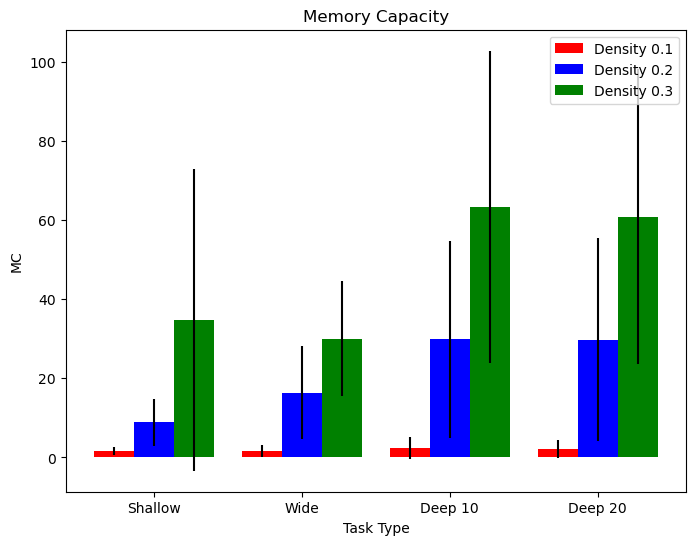

In [1087]:
## N = unpickled_df[0].shape[1]

ind = np.arange(N)
fig,ax=plt.subplots(1,figsize=(8,6))
plt.rcParams['pdf.fonttype'] = 42
width = 0.27
rects1 = ax.bar(ind, unpickled_df[0].loc['Mean',:],width, yerr=unpickled_df[0].loc['STD',:], color='r')
rects2 = ax.bar(ind+width, unpickled_df[1].loc['Mean',:],width, yerr=unpickled_df[1].loc['STD',:],  color='b')
rects3 = ax.bar(ind+width*2, unpickled_df[2].loc['Mean',:], width, yerr=unpickled_df[2].loc['STD',:], color='g')
ax.legend( (rects1[0], rects2[0], rects3[0]), ('Density 0.1', 'Density 0.2', 'Density 0.3') )

# plt.bar(np.arange(unpickled_df[0].shape[1]),unpickled_df[0].mean(), yerr=stds, capsize=6)
ax.set_xticks(ind+width)
# ax.set_title('MC Task')
ax.set_xlabel('Task Type')
ax.set_xticklabels(['Shallow','Wide','Deep 10','Deep 20'])
plt.title('Memory Capacity')
ax.set_ylabel('MC')
# ax.set_ylim([0.85,0.95])
saveFig='/import/silo2/aloe8475/Documents/Data/Figures/Functional Connectivity/'
plt.savefig(saveFig+"Memory Capacity 3 Densities - Single vs Wide vs Deep NWN.png")
plt.savefig(saveFig+"Memory Capacity 3 Densities - Single vs Wide vs Deep NWN.pdf",format='pdf',dpi=300)
plt.show()

### NARMA TASK

In [904]:
def get_NARMA_deep(Graph,amp = 2, signal=[], voltageInputs=[],elecs=[], dt = 0.01, dur = 1, hist = 9, shift = 0.1,n_outs = 100, init_state = None, return_sim = False,seed=42):
    ampName=str(amp).replace('.','p')
    np.random.seed(seed)
    stimulus=[]
#     y = np.zeros(len(signal))
    N = Graph.number_of_nodes#Connectivity.number_of_wires

    if elecs:
        electrodes=elecs
        contactMode='preSet'
        for volt in voltageInputs:
            stimulus.append(stimulus__(biasType='Custom',T=30,dt=dt,customSignal=volt))#signal_expand(np.random.random(1000)*2*volt-volt, dur)))
        stimulus.append(stimulus__(biasType='Drain',T=30,dt=dt)) #we don't want this drain to be active during training
    else:
        electrodes=None
        contactMode='farthest'
        stimulus.append(stimulus__(biasType='Custom',T=30,dt=dt,customSignal=signal))#signal_expand((np.random.random(1000)*2*amp-amp), dur)))
        stimulus.append(stimulus__(biasType='Drain',T=30,dt=dt)) #we don't want this drain to be active during training
    
#         y[i] = 0.1*y[i-1] + 0.004*y[i-1]*np.sum(y[i-hist:i]) + 2*u[i-hist]*u[i-1] + 0.1
#         y[i] = 0.01*y[i-1] + 0.0004*y[i-1]*np.sum(y[i-hist:i]) + 1.5*u[i-hist]*u[i-1] + shift    
    
    simRAND = runSim(connectivity__(graph=Graph), T = 30, dt = dt,
#                 start_state =  init_state,
                stimulus=stimulus,
#                 biasType = 'Custom', customSignal = u, 
                junctionMode = 'tunneling', 
                contactMode = contactMode,
                electrodes=electrodes,
                findFirst=False, disable_tqdm=True)
    
#     set_trace()
#     wire_voltage = simRAND.wireVoltage
# #     node_list = np.random.choice(range(0, N), n_outs, replace = False)
    node_list=[]
    for i in range(len(Graph.nodes)):
        node_list.append(i)

#     k = 200
#     lhs = wire_voltage[k:,node_list]
#     rhs = signal[k:]
#     weight = np.linalg.lstsq(lhs, rhs, rcond = None)[0]
#     result = np.matmul(lhs, weight)
#     acc = 1-getRNMSE(result, rhs)
    
#     weight_time=[]
#     for i in range(len(y)):
#         weight_time.append(np.linalg.lstsq(lhs[i:i+1],rhs[i:i+1])[0])

    if return_sim:
        return simRAND, node_list
    else:
        return u, node_list
    
    

In [905]:
def get_NARMA_single(Graph,amp = 2, signal=[], voltageInputs=[],elecs=[], dt = 0.01, dur = 1, hist = 9, shift = 0.1,n_outs = 100, init_state = None, return_sim = False,seed=42):
    ampName=str(amp).replace('.','p')
    np.random.seed(seed)
    stimulus=[]
    y = np.zeros(len(signal))
    N = Graph.number_of_nodes#Connectivity.number_of_wires
    
    electrodes=None
    contactMode='farthest'
    stimulus.append(stimulus__(biasType='Custom',T=30,dt=dt,customSignal=signal))#signal_expand((np.random.random(1000)*2*amp-amp), dur)))
    stimulus.append(stimulus__(biasType='Drain',T=30,dt=dt)) #we don't want this drain to be active during training
    
    simRAND = runSim(connectivity__(graph=Graph), T = 30, dt = dt,
#                 start_state =  init_state,
                stimulus=stimulus,
#                 biasType = 'Custom', customSignal = u, 
                junctionMode = 'tunneling', 
                contactMode = contactMode,
                electrodes=electrodes,
                findFirst=False, disable_tqdm=True)
    
#     set_trace()
    wire_voltage = simRAND.wireVoltage
#     node_list = np.random.choice(range(0, N), n_outs, replace = False)

    for m in range(hist, len(signal)):
        y[m] = 0.3*y[m-1] + 1.5*signal[m-hist]*signal[m-1] + 0.1 #0.5 is scaling the amplitude
        
    k = 200
    lhs = wire_voltage[k:,:]
    rhs = y[k:]
    weight = np.linalg.lstsq(lhs, rhs, rcond = None)[0]
    result = np.matmul(lhs, weight)
    acc = 1-getRNMSE(result, rhs)
    
#     weight_time=[]
#     for i in range(len(y)):
#         weight_time.append(np.linalg.lstsq(lhs[i:i+1],rhs[i:i+1])[0])

    if return_sim:
        return acc,simRAND, node_list
    else:
        return acc, node_list
    
    

In [906]:
#SINGLE NETWORK:
amp=0.5;dur=1;hist=9;shift=0.1;
numRep=10#number of repeats
NARMA_single=np.zeros(numRep)

for i in tqdm(range(len(a))):
    signal=[None]*numRep
    W=[None]*numRep
    for j in tqdm(range(numRep)):
        np.random.seed(seeds[j])
        u[j] = signal_expand((np.random.random(3000)*amp)+2, dur)
        NARMA_single[j],simNARMA_single,node_list=get_NARMA_single(b[i],signal=u[j],amp=amp,return_sim=True,seed=seeds[j])
        print(NARMA_single[j])

0.9247039922953982
0.9227221878714976
0.9234177654919999
0.923405349101531
0.9244832910443368
0.925548803064587
0.9239806924990013
0.9243283024211557
0.9233461966927052
0.9227860914902731



0.924146953084135
0.9218135066738511
0.9237106671304539
0.9232486342562788
0.9246473607794646
0.9245337997214816
0.9232599242247596
0.9249508776666566
0.922200706530341
0.9226472249056943



0.9243057281235112
0.9220996952546234
0.9234835986588692
0.9225851710609263
0.9249276357638101
0.9243884466797515
0.9240988469643427
0.9242837610619672
0.9226558137843355
0.92384024093289



0.9239549937003673
0.9223880683116399
0.9228029221227558
0.9233301944247464
0.9240857786448189
0.9232313242785948
0.9235294073911123
0.9242418705031966
0.9232630692111492
0.9231810121471223



0.9249810039043094
0.9236201571134096
0.9243021085458054
0.9229020556479088
0.9252177081193519
0.9247468162112871
0.9236438212022005
0.9252519341723903
0.9232652645452075
0.9242503099331303



0.9250322767953465
0.9234434262433926
0.9245908613494019
0.9235961257898798
0.925274352382089
0.9253329055433787
0.9247016622726724
0.925953440617759
0.9242171605660338
0.9239529104990003



0.9243211321386937
0.9221879238044154
0.9233546923082694
0.9238720596491021
0.9244115678414594
0.9243143488162195
0.924357515843302
0.9243187669633144
0.9232830412725392
0.9230040044318131



0.9246890189813753
0.9221199689329196
0.9240964915999367
0.9229041369907752
0.9248582936564183
0.9245818945504466
0.9235395717466091
0.9243236357274287
0.922345947363204
0.9237771917928506



0.9235408738115751
0.922916789946073
0.9235021947107569
0.9230479023744875
0.9252759966412888
0.9235218746293357
0.9235631003634163
0.9238079299648922
0.9222285737398213
0.9229834502606168



0.9241721999392126
0.9230549851957919
0.9237855788840765
0.9238616327840837
0.9250501852256848
0.9254219822804304
0.9245166560026254
0.9249283169756484
0.9230618538057851
0.9234030294098543




In [907]:
print(np.std(NARMA_single))
np.mean(NARMA_single)

0.0007949898783127078


0.9241256420503193

In [910]:
# WIDE NETWORKS:
def runWideNARMA(a,numRep):
    amp=0.5;dur=1;histv=9;shift=0.1;
    NARMA_final_wide=[[]*numRep for i in range(len(a))]
    simNARMA_wide=[None]*3
    for i in tqdm(range(len(a))): #for each network
        u=[None]*numRep
        for j in tqdm(range(numRep)): # for each seed
            np.random.seed(seeds[j])
            u[j] = signal_expand((np.random.random(3000)*amp)+2, dur)
            y = np.zeros(len(u[j]))
            for m in range(histv, len(u[j])):
                #simple test:
                y[m] = 0.3*y[m-1] + 1.5*(u[j][m-histv])*(u[j][m-1]) + 0.1 #0.2 is scaling the amplitude

            #generate signals:
            np.random.seed(seeds[i])
            simNARMA_wide[0],node_list=get_NARMA_deep(a[i],signal=u[j],amp=amp,return_sim=True,seed=seeds[j])
            simNARMA_wide[1],node_list=get_NARMA_deep(a[i],signal=u[j],amp=amp,return_sim=True,seed=seeds[j])
            simNARMA_wide[2],node_list=get_NARMA_deep(a[i],signal=u[j],amp=amp,return_sim=True,seed=seeds[j])

            wire_voltage = np.hstack((simNARMA_wide[0].wireVoltage,simNARMA_wide[1].wireVoltage,simNARMA_wide[2].wireVoltage))
#                 y[m] = 0.1*y[m-1] + 0.004*y[m-1]*np.sum(y[m-histv:j]) + 2*u[j][m-histv]*u[j][m-1] + 0.1
        #         y[j] = 0.01*y[j-1] + 0.0004*y[j-1]*np.sum(y[j-histv:j]) + 1.5*u[j-histv]*u[j-1] + shift       
#             y=np.hstack([y]*3)
            k = 200
            lhs = wire_voltage[k:,:]
            rhs = y[k:]
#             set_trace()
            weight = np.linalg.lstsq(lhs, rhs, rcond = None)[0]
            result = np.matmul(lhs, weight)
            NARMA_final_wide[i].append(1-getRNMSE(result, rhs))
    return NARMA_final_wide

In [911]:
NARMA_wide_vals=runWideNARMA(a,numRep)

In [912]:
print(np.std(NARMA_wide_vals))
np.mean(NARMA_wide_vals)

0.0012362260392750162


0.9106446562946542

In [919]:
#DEEP NETWORKS:
def runDeepNARMA(a,numInputs,numRep,amp=0.5,ampFloor=2):
    simNARMA_deep=[None]*3
    NARMA_deep=[None]*3
    dur=1;histv=9;shift=0.1;
    #3 sub reservoirs with 10 INPUTS
    NARMA_final_deep=[]#[]*numRep for i in range(len(a))]

    for i in tqdm(range(len(a))): #for each network
        u=[None]*numRep
        for j in tqdm(range(numRep)): # for each seed
            np.random.seed(seeds[j])
            u[j] = signal_expand((np.random.random(3000)*amp)+ampFloor, dur)
            y = np.zeros(len(u[j]))
            for m in range(histv, len(u[j])):
                #simple test:
                y[m] = 0.3*y[m-1] + 1.5*(u[j][m-histv])*(u[j][m-1]) + 0.1 #0.2 is scaling the amplitude
#                 y[m] = 0.3*y[m-1] + 0.05*y[m-1]*np.sum(y[m-histv:m]) + 1.5*u[j][m-histv]*u[j][m-1] + 0.1
#                 y[m] = 0.1*y[m-1] + 0.004*y[m-1]*np.sum(y[m-histv:j]) + 2*u[j][m-histv]*u[j][m-1] + 0.1
        #         y[j] = 0.01*y[j-1] + 0.0004*y[j-1]*np.sum(y[j-histv:j]) + 1.5*u[j-histv]*u[j-1] + shift     
#             set_trace()
            simNARMA_deep[0],node_list=get_NARMA_deep(a[i],signal=u[j],amp=amp,return_sim=True,seed=seeds[j])
            
            simNARMA_deep[1],node_list=addSubReservoir(a[i],simNARMA_deep[0],
                                                numInputs,signal=y,
                                                amp=amp,seed=seeds[j],
                                                analysisType='NARMA')
        
            simNARMA_deep[2],node_list=addSubReservoir(a[i],simNARMA_deep[1],
                                                numInputs,signal=y,
                                                amp=amp,seed=seeds[j],
                                                removeSources=True,analysisType='NARMA')
        
            wire_voltage = np.hstack((simNARMA_deep[0].wireVoltage,simNARMA_deep[1].wireVoltage,simNARMA_deep[2].wireVoltage))

#             y=np.hstack([y]*3)
            k = 200
            
            lhs = wire_voltage[k:,:]
            rhs = y[k:]
            weight = np.linalg.lstsq(lhs, rhs, rcond = None)[0]
            result = np.matmul(lhs, weight)
            NARMA_final_deep.append(1-getRNMSE(result, rhs))
            print(NARMA_final_deep[j])
    return NARMA_final_deep

In [ ]:
# amp=np.arange(0.5,3.1,0.5)
# ampFloor=np.arange(0.5,3.1,0.5)

# NARMA_final_deep=[[] for i in range(len(amp))]
# NARMA_final_deep_std=[[] for i in range(len(amp))]
# count=0
# for i in tqdm(amp):
#     for j in ampFloor:
#         tmp=runDeepNARMA(a,len(amp),numRep=10,amp=i,ampFloor=j)
#         NARMA_final_deep[count].append(np.mean(tmp))
#         NARMA_final_deep_std[count].append(np.std(tmp))
#     count = count+1
# # MG_final_deep50=runDeepMG(a,50)

In [913]:
# f=plt.figure()
# p1=plt.imshow(np.array(NARMA_final_deep))
# ax=plt.gca()
# plt.title('Deep NWN 100-Nodes/Layer - NARMA10')
# plt.xlabel('Floor Amplitude (V)')
# ax.set_xticks(range(len(amp)))
# ax.set_xticklabels(amp)
# ax.set_yticks(range(len(amp)))
# ax.set_yticklabels(amp)
# plt.ylabel('Signal Amplitude (V)')
# plt.colorbar(label='1-RNMSE')
# plt.show()
# f.savefig(saveFig+"NARMA10 Voltage Analysis - Floor Amp vs Signal Amp.png")
# f.savefig(saveFig+"NARMA10 Voltage Analysis - Floor Amp vs Signal Amp.pdf",format='pdf',dpi=300)


In [825]:
# NARMA_final_deep=[]
# NARMA_final_deep_std=[]
# r=range(1,11)
# r=np.hstack((r,[15,20,30,40,50]))
# for i in tqdm(r):
#     tmp=runDeepMG(a,i)
#     NARMA_final_deep.append(np.mean(tmp))
#     NARMA_final_deep_std.append(np.std(tmp))

# # MG_final_deep50=runDeepMG(a,50)

In [920]:
NARMA_final_deep10=runDeepNARMA(a,10,numRep)
NARMA_final_deep20=runDeepNARMA(a,20,numRep)
# NARMA_final_deep100=runDeepNARMA(a,98,numRep)

0.9247339521871649
0.9216279156477588
0.9240291752572068
0.9231339269923723
0.9246506673689462
0.9239394823040862
0.9234983967722442
0.9248477270545518
0.9226208830823263
0.9228365650893091



0.9247339521871649
0.9216279156477588
0.9240291752572068
0.9231339269923723
0.9246506673689462
0.9239394823040862
0.9234983967722442
0.9248477270545518
0.9226208830823263
0.9228365650893091



0.9247339521871649
0.9216279156477588
0.9240291752572068
0.9231339269923723
0.9246506673689462
0.9239394823040862
0.9234983967722442
0.9248477270545518
0.9226208830823263
0.9228365650893091



0.9247339521871649
0.9216279156477588
0.9240291752572068
0.9231339269923723
0.9246506673689462
0.9239394823040862
0.9234983967722442
0.9248477270545518
0.9226208830823263
0.9228365650893091



0.9247339521871649
0.9216279156477588
0.9240291752572068
0.9231339269923723
0.9246506673689462
0.9239394823040862
0.9234983967722442
0.9248477270545518
0.9226208830823263
0.9228365650893091



0.9247339521871649
0.9216279156477588
0.9240291752572068
0.9231339269923723
0.9246506673689462
0.9239394823040862
0.9234983967722442
0.9248477270545518
0.9226208830823263
0.9228365650893091



0.9247339521871649
0.9216279156477588
0.9240291752572068
0.9231339269923723
0.9246506673689462
0.9239394823040862
0.9234983967722442
0.9248477270545518
0.9226208830823263
0.9228365650893091



0.9247339521871649
0.9216279156477588
0.9240291752572068
0.9231339269923723
0.9246506673689462
0.9239394823040862
0.9234983967722442
0.9248477270545518
0.9226208830823263
0.9228365650893091



0.9247339521871649
0.9216279156477588
0.9240291752572068
0.9231339269923723
0.9246506673689462
0.9239394823040862
0.9234983967722442
0.9248477270545518
0.9226208830823263
0.9228365650893091



0.9247339521871649
0.9216279156477588
0.9240291752572068
0.9231339269923723
0.9246506673689462
0.9239394823040862
0.9234983967722442
0.9248477270545518
0.9226208830823263
0.9228365650893091




0.9233963495287137
0.9216529474917903
0.9229380198168787
0.9227610650064062
0.9243289559980055
0.9232444145339789
0.9223528711308322
0.9232144244420353
0.9214969368024916
0.9230178888171814



0.9233963495287137
0.9216529474917903
0.9229380198168787
0.9227610650064062
0.9243289559980055
0.9232444145339789
0.9223528711308322
0.9232144244420353
0.9214969368024916
0.9230178888171814



0.9233963495287137
0.9216529474917903
0.9229380198168787
0.9227610650064062
0.9243289559980055
0.9232444145339789
0.9223528711308322
0.9232144244420353
0.9214969368024916
0.9230178888171814



0.9233963495287137
0.9216529474917903
0.9229380198168787
0.9227610650064062
0.9243289559980055
0.9232444145339789
0.9223528711308322
0.9232144244420353
0.9214969368024916
0.9230178888171814



0.9233963495287137
0.9216529474917903
0.9229380198168787
0.9227610650064062
0.9243289559980055
0.9232444145339789
0.9223528711308322
0.9232144244420353
0.9214969368024916
0.9230178888171814



0.9233963495287137
0.9216529474917903
0.9229380198168787
0.9227610650064062
0.9243289559980055
0.9232444145339789
0.9223528711308322
0.9232144244420353
0.9214969368024916
0.9230178888171814



0.9233963495287137
0.9216529474917903
0.9229380198168787
0.9227610650064062
0.9243289559980055
0.9232444145339789
0.9223528711308322
0.9232144244420353
0.9214969368024916
0.9230178888171814



0.9233963495287137
0.9216529474917903
0.9229380198168787
0.9227610650064062
0.9243289559980055
0.9232444145339789
0.9223528711308322
0.9232144244420353
0.9214969368024916
0.9230178888171814



0.9233963495287137
0.9216529474917903
0.9229380198168787
0.9227610650064062
0.9243289559980055
0.9232444145339789
0.9223528711308322
0.9232144244420353
0.9214969368024916
0.9230178888171814



0.9233963495287137
0.9216529474917903
0.9229380198168787
0.9227610650064062
0.9243289559980055
0.9232444145339789
0.9223528711308322
0.9232144244420353
0.9214969368024916
0.9230178888171814




In [921]:
stdsNARMA=np.hstack((np.std(NARMA_single),np.std(NARMA_wide_vals),np.std(NARMA_final_deep10),np.std(NARMA_final_deep20)))#,np.std(NARMA_final_deep100)))

In [922]:
import pandas as p
df=pd.DataFrame({'Single':{'Mean':np.mean(NARMA_single),'STD':np.std(NARMA_single)},'Wide':{'Mean':np.mean(NARMA_wide_vals),'STD':np.std(NARMA_wide_vals)},'Deep 10':{'Mean':np.mean(NARMA_final_deep10),'STD':np.std(NARMA_final_deep10)},'Deep 20':{'Mean':np.mean(NARMA_final_deep20),'STD':np.std(NARMA_final_deep20)}})

In [1000]:
df.to_pickle(dataLoc+densityName+"NARMA.pkl")

In [1082]:
## Load all densities:
densities=[0.10,0.20,0.30]
unpickled_df=[None]*3
for i in range(len(densities)):
    density=densities[i]
    densityName=str(density).replace('.','p')
    loadLoc='/import/silo2/aloe8475/Documents/Data/Functional Connectivity/Hierarchical Networks/Deep NWN Hierarchy/Density '+"{:.2f}".format(density)+'/'
    unpickled_df[i]=(pd.read_pickle(loadLoc+densityName+'NARMA.pkl'))

In [1083]:
unpickled_df

[        Single      Wide   Deep 10   Deep 50
 Mean  0.920674  0.909830  0.909830  0.909830
 STD   0.001025  0.001055  0.001055  0.001055,
         Single      Wide   Deep 10   Deep 50
 Mean  0.922584  0.910956  0.910956  0.910956
 STD   0.000909  0.001405  0.001405  0.001405,
         Single      Wide   Deep 10   Deep 20
 Mean  0.924126  0.910645  0.922458  0.921528
 STD   0.000795  0.001236  0.001866  0.002001]

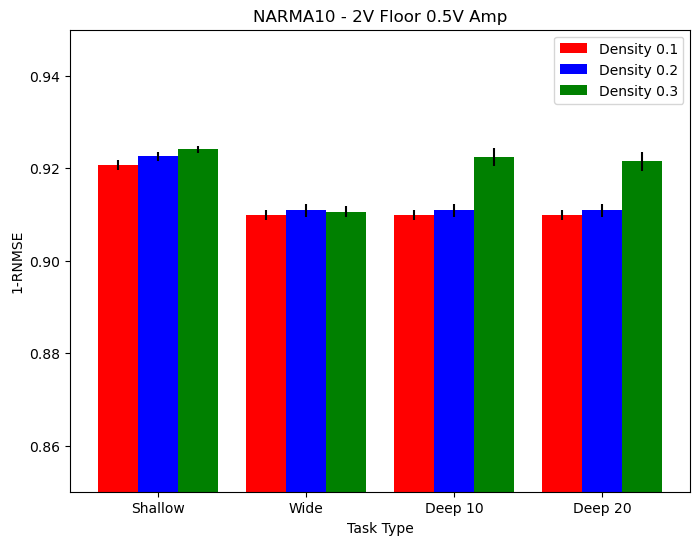

In [1084]:
## N = unpickled_df[0].shape[1]
ind = np.arange(N)
fig,ax=plt.subplots(1,figsize=(8,6))
plt.rcParams['pdf.fonttype'] = 42
width = 0.27
rects1 = ax.bar(ind, unpickled_df[0].loc['Mean',:],width, yerr=unpickled_df[0].loc['STD',:], color='r')
rects2 = ax.bar(ind+width, unpickled_df[1].loc['Mean',:],width, yerr=unpickled_df[1].loc['STD',:],  color='b')
rects3 = ax.bar(ind+width*2, unpickled_df[2].loc['Mean',:], width, yerr=unpickled_df[2].loc['STD',:], color='g')
ax.legend( (rects1[0], rects2[0], rects3[0]), ('Density 0.1', 'Density 0.2', 'Density 0.3') )

# plt.bar(np.arange(unpickled_df[0].shape[1]),unpickled_df[0].mean(), yerr=stds, capsize=6)
ax.set_xticks(ind+width)
# ax.set_title('MC Task')
ax.set_xlabel('Task Type')
ax.set_xticklabels(['Shallow','Wide','Deep 10','Deep 20'])
plt.title('NARMA10 - 2V Floor 0.5V Amp')
ax.set_ylabel('1-RNMSE')
ax.set_ylim([0.85,0.95])
saveFig='/import/silo2/aloe8475/Documents/Data/Figures/Functional Connectivity/'
plt.savefig(saveFig+"NARMA10 3 Densities - Single vs Wide vs Deep NWN.png")
plt.savefig(saveFig+"NARMA10 3 Densities - Single vs Wide vs Deep NWN.pdf",format='pdf',dpi=300)
plt.show()

### MACKEY-GLASS TIME-SERIES

In [924]:
def get_MG_deep(Graph, amp = 1, 
          dt = 0.01, dur = 1, 
          hist = 20, shift = 2,
          n_outs = 10,signal=[], voltageInputs=[],elecs=[], 
          init_state = None, seed=42,
          return_sim = False):    
    
    ampName=str(amp).replace('.','p')
    np.random.seed(seed)
    stimulus=[]
#     y = np.zeros(len(signal))
    N = Graph.number_of_nodes#Connectivity.number_of_wires

    if elecs:
        electrodes=elecs
        contactMode='preSet'
#         set_trace()
        for volt in voltageInputs:
            stimulus.append(stimulus__(biasType='Custom',T=30,dt=dt,customSignal=volt))#signal_expand(np.random.random(1000)*2*volt-volt, dur)))
        stimulus.append(stimulus__(biasType='Drain',T=30,dt=dt)) #we don't want this drain to be active during training
    else:
        electrodes=None
        contactMode='farthest'
        stimulus.append(stimulus__(biasType='Custom',T=30,dt=dt,customSignal=signal))#signal_expand((np.random.random(1000)*2*amp-amp), dur)))
        stimulus.append(stimulus__(biasType='Drain',T=30,dt=dt)) #we don't want this drain to be active during training
    
    simRAND = runSim(connectivity__(graph=Graph), T = 30, dt = dt,
#                 start_state =  init_state,
                stimulus=stimulus,
#                 biasType = 'Custom', customSignal = u, 
                junctionMode = 'tunneling', 
                contactMode = contactMode,
                electrodes=electrodes,
                findFirst=False, disable_tqdm=True)
    
    node_list=[]
    for i in range(len(Graph.nodes)):
        node_list.append(i)


    if return_sim:
        return simRAND, node_list
    else:
        return u, node_list
    

In [925]:
def get_MG_single(Graph, amp = 1, 
          dt = 0.01, dur = 1, 
          hist = 20, shift = 2,
          n_outs = 10,signal=[], voltageInputs=[],elecs=[], 
          init_state = None, seed=42,
          return_sim = False):    
    ampName=str(amp).replace('.','p')
    np.random.seed(seed)
    stimulus=[]
    N = Graph.number_of_nodes#Connectivity.number_of_wires
    
    electrodes=None
    contactMode='farthest'
    stimulus.append(stimulus__(biasType='Custom',T=30,dt=dt,customSignal=signal))#signal_expand((np.random.random(1000)*2*amp-amp), dur)))
    stimulus.append(stimulus__(biasType='Drain',T=30,dt=dt)) #we don't want this drain to be active during training
    
    simRAND = runSim(connectivity__(graph=Graph), T = 30, dt = dt,
#                 start_state =  init_state,
                stimulus=stimulus,
#                 biasType = 'Custom', customSignal = u, 
                junctionMode = 'tunneling', 
                contactMode = contactMode,
                electrodes=electrodes,
                findFirst=False, disable_tqdm=True)
    
#     set_trace()
    wire_voltage = simRAND.wireVoltage
#     node_list = np.random.choice(range(0, N), n_outs, replace = False)
    node_list=[]
    for i in range(len(Graph.nodes)):
        node_list.append(i)
        
    lhs = wire_voltage[:-hist,node_list]
    rhs = y[hist:]
    weight = np.linalg.lstsq(lhs, rhs, rcond = None)[0]
    result = np.matmul(lhs, weight)
    acc = 1-getRNMSE(result, rhs)

    if return_sim:
        return acc,simRAND, node_list
    else:
        return acc, node_list
    
    

In [962]:
#SINGLE NETWORK:
amp=2;dur=1;hist=20;shift=2;dt=0.01
numRep=10#number of repeats
MG_single=np.zeros(numRep)

for i in tqdm(range(len(b))):
    y = mkg_generator(3000, 100*dt, tau=18)
    MG_single[i],simMG_single,node_list=get_MG_single(b[i],signal=y,amp=amp,return_sim=True,seed=seeds[j])
    print(MG_single[i])

0.6981917252771774
0.699952968780913
0.7111109254809769
0.6910174868003689
0.6974791321362565
0.6873129320626938
0.6874282868125585
0.6772840200285588
0.6966307719778317
0.689148740705628



In [963]:
print(np.std(MG_single))
np.mean(MG_single)

0.008732707694416322


0.6935556990062963

In [964]:
# WIDE NETWORKS:
def runWideMG(a):
    amp=2;dur=1;hist=20;shift=2;dt=0.01
    MG_final_wide=[]
    simMG_wide=[None]*3
    for i in tqdm(range(len(a))): #for each network
        np.random.seed(seeds[i])
        y = mkg_generator(3000, 100*dt, 18)
        #generate signals:
        simMG_wide[0],node_list=get_MG_deep(a[i],signal=y,amp=amp,return_sim=True)
        simMG_wide[1],node_list=get_MG_deep(a[i],signal=y,amp=amp,return_sim=True)
        simMG_wide[2],node_list=get_MG_deep(a[i],signal=y,amp=amp,return_sim=True)
        wire_voltage = np.hstack((simMG_wide[0].wireVoltage,simMG_wide[1].wireVoltage,simMG_wide[2].wireVoltage))

        lhs = wire_voltage[:-hist,:]
        rhs = y[hist:]
        weight = np.linalg.lstsq(lhs, rhs, rcond = None)[0]
        result = np.matmul(lhs, weight)
        MG_final_wide.append(1-getRNMSE(result, rhs))
    return MG_final_wide

In [965]:
MG_wide_vals=runWideMG(a)

In [966]:
MG_wide_vals

[0.6004716594428874,
 0.6049236889171961,
 0.6026723471718816,
 0.6036724971412205,
 0.6031602856373381,
 0.6089185284767848,
 0.6026131025182428,
 0.6073352085223047,
 0.6064845420518752,
 0.6073744074059457]

In [1]:
#DEEP NETWORKS:
def runDeepMG(a,numInputs):
    simMG_deep=[None]*3
    amp=2;dur=1;hist=20;shift=0.1;dt=0.01
    #3 sub reservoirs with 10 INPUTS
    MG_final_deep = []
    for i in tqdm(range(len(a))): #for each network
        np.random.seed(seeds[i])
        y = mkg_generator(3000, 100*dt, 18)
        
        #sub-res 1
        simMG_deep[0],node_list=get_MG_deep(a[i],signal=y,amp=amp,return_sim=True,seed=seeds[i])
        
    #list of all wires
        simMG_deep[1],node_list=addSubReservoir(a[i],simMG_deep[0],
                                                numInputs,signal=y,
                                                amp=amp,seed=seeds[i],
                                                analysisType='MG')
        
        simMG_deep[2],node_list=addSubReservoir(a[i],simMG_deep[1],
                                                numInputs,signal=y,
                                                amp=amp,seed=seeds[i],
                                                removeSources=True,analysisType='MG')

        #Combine outputs
        wire_voltage = np.hstack((simMG_deep[0].wireVoltage,simMG_deep[1].wireVoltage,simMG_deep[2].wireVoltage))
        
        lhs = wire_voltage[:-hist,:]
        
        rhs = y[hist:]
        weight = np.linalg.lstsq(lhs, rhs, rcond = None)[0]
        result = np.matmul(lhs, weight)
        
        MG_final_deep.append(1-getRNMSE(result, rhs))
        print(MG_final_deep[i])
#         break;
    return MG_final_deep

In [2]:
# MG_final_deep=[]
# r=range(1,11)
# r=np.hstack((r,[15,20,30,40,50]))
# for i in tqdm(r):
#     MG_final_deep.append(runDeepMG(a,i))
# # MG_final_deep50=runDeepMG(a,50)

In [3]:
# # plt.plot(MG_final_deep)
# f=plt.figure()
# plt.title('Number of Connecting Nodes bw Subreservoirs')
# ax=plt.gca()
# # plt.plot(MG_final_deep)
# p1,=ax.plot(r,NARMA_final_deep,c='r')
# ax.fill_between(r,np.array(NARMA_final_deep)+np.array(NARMA_final_deep_std/np.sqrt(10)),np.array(NARMA_final_deep)-np.array(NARMA_final_deep_std/np.sqrt(10)),color='r',alpha=0.3)

# p2,=ax.plot(r,MG_final_deep,c='b')
# ax2=ax.twinx()
# p3,=ax2.plot(r,MC_final_deep,c='g')
# ax2.fill_between(r,np.array(MC_final_deep)+np.array(MC_final_deep_std/np.sqrt(10)),np.array(MC_final_deep)-np.array(MC_final_deep_std/np.sqrt(10)),color='g',alpha=0.3)
# ax2.tick_params(axis='y', colors='g')
# ax2.yaxis.label.set_color('g')        #setting up X-axis label color to green

# plt.legend([p1,p2,p3],['NARMA10','MG','MC'])

# ax.set_xlabel('Num Connecting Nodes')
# ax.set_ylabel('1-RNMSE')
# ax2.set_ylabel('MC')
# plt.show()
# f.savefig(saveFig+'Number of Connecting Nodes between Subreservoirs NARMA+MG+MC.png')
# f.savefig(saveFig+'Number of Connecting Nodes between Subreservoirs NARMA+MG+MC.pdf',format='pdf',dpi=300)

In [970]:
#10 different networks
MG_final_deep10=runDeepMG(a,10)
MG_final_deep20=runDeepMG(a,20)


0.6738063703647871
0.6841042060195848
0.6396337201496038
0.6310743354612862
0.707557309237858
0.6931782617003504
0.6926184242232258
0.671302260225674
0.6668075973638015
0.6893952221327015



0.6543897902709257
0.6635672574213352
0.6306423710515031
0.633858922881102
0.6780568911141611
0.6804491253905289
0.6863013076579116
0.667751579202105
0.6611200271473109
0.6820739636025505



In [971]:
stdsMG=np.hstack((np.std(MG_single),np.std(MG_wide_vals),np.std(MG_final_deep10),np.std(MG_final_deep20)))#,np.std(NARMA_final_deep100)))

In [972]:
import pandas as p
df=pd.DataFrame({'Single':{'Mean':np.mean(MG_single),'STD':np.std(MG_single)},'Wide':{'Mean':np.mean(MG_wide_vals),'STD':np.std(MG_wide_vals)},'Deep 10':{'Mean':np.mean(MG_final_deep10),'STD':np.std(MG_final_deep10)},'Deep 20':{'Mean':np.mean(MG_final_deep20),'STD':np.std(MG_final_deep20)}})

In [973]:
densityName

'0p2'

In [974]:
df.to_pickle(dataLoc+densityName+"MG.pkl")

In [1079]:
## Load all densities:
densities=[0.10,0.20,0.30]
unpickled_df=[None]*3
for i in range(len(densities)):
    density=densities[i]
    densityName=str(density).replace('.','p')
    loadLoc='/import/silo2/aloe8475/Documents/Data/Functional Connectivity/Hierarchical Networks/Deep NWN Hierarchy/Density '+"{:.2f}".format(density)+'/'
    unpickled_df[i]=(pd.read_pickle(loadLoc+densityName+'MG.pkl'))

In [1080]:
unpickled_df

[        Single      Wide   Deep 10   Deep 20
 Mean  0.672997  0.598658  0.636978  0.627844
 STD   0.013771  0.004950  0.017907  0.020576,
         Single      Wide   Deep 10   Deep 20
 Mean  0.693556  0.604763  0.674948  0.663821
 STD   0.008733  0.002547  0.022920  0.018515,
         Single      Wide   Deep 10   Deep 20
 Mean  0.697039  0.606119  0.687143  0.683989
 STD   0.010425  0.002622  0.007563  0.009035]

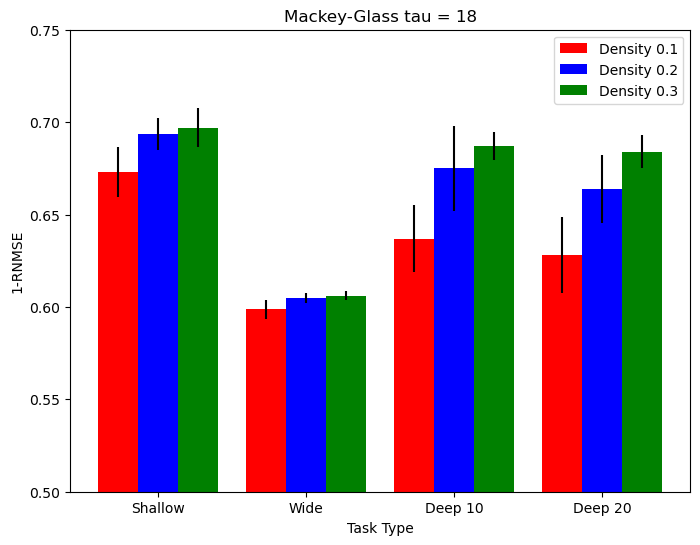

In [1081]:
N = unpickled_df[0].shape[1]
ind = np.arange(N)
fig,ax=plt.subplots(1,figsize=(8,6))
plt.rcParams['pdf.fonttype'] = 42
width = 0.27
rects1 = ax.bar(ind, unpickled_df[0].loc['Mean',:],width, yerr=unpickled_df[0].loc['STD',:], color='r')
rects2 = ax.bar(ind+width, unpickled_df[1].loc['Mean',:],width, yerr=unpickled_df[1].loc['STD',:],  color='b')
rects3 = ax.bar(ind+width*2, unpickled_df[2].loc['Mean',:], width, yerr=unpickled_df[2].loc['STD',:], color='g')
ax.legend( (rects1[0], rects2[0], rects3[0]), ('Density 0.1', 'Density 0.2', 'Density 0.3') )

# plt.bar(np.arange(unpickled_df[0].shape[1]),unpickled_df[0].mean(), yerr=stds, capsize=6)
ax.set_xticks(ind+width)
# ax.set_title('MC Task')
ax.set_xlabel('Task Type')
ax.set_xticklabels(['Shallow','Wide','Deep 10','Deep 20'])
plt.title('Mackey-Glass tau = 18')
ax.set_ylabel('1-RNMSE')
ax.set_ylim([0.5,0.75])
saveFig='/import/silo2/aloe8475/Documents/Data/Figures/Functional Connectivity/'
plt.savefig(saveFig+"Mackey-Glass 3 Densities - Single vs Wide vs Deep NWN.png")
plt.savefig(saveFig+"Mackey-Glass 3 Densities - Single vs Wide vs Deep NWN.pdf",format='pdf',dpi=300)

plt.show()